In [34]:
import numpy as np
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

In [35]:
import numpy as np
from qiskit.circuit.library import QFT

def add_constant_mod_N(circuit, reg, ancilla, C, N):
    """
    |x> -> |(x + C) mod N>
    """
    n = len(reg)
    
    # 1. +C (無条件加算)
    for i in range(n):
        angle = 2 * np.pi * C / (2**(n - i))
        if abs(angle) > 1e-9:
            circuit.p(angle, reg[i])
            
    # 2. -N (試し引き)
    for i in range(n):
        angle = -2 * np.pi * N / (2**(n - i))
        if abs(angle) > 1e-9:
            circuit.p(angle, reg[i])
            
    # 3. 符号チェック (MSB確認)
    circuit.append(QFT(n, do_swaps=False, inverse=True).to_gate(), reg)
    circuit.cx(reg[-1], ancilla) # 負ならアンシラが1になる
    circuit.append(QFT(n, do_swaps=False).to_gate(), reg)
    
    # 4. 補正 (+N)
    # アンシラが1(負になった)なら、Nを足して正に戻す
    for i in range(n):
        angle = 2 * np.pi * N / (2**(n - i))
        if abs(angle) > 1e-9:
            circuit.cp(angle, ancilla, reg[i])
            
    # --- ここで計算自体は完了しています ---
    
    # 5. アンシラの後始末 (簡易版)
    # 本来は「逆演算」が必要ですが、コンペのこの段階やシミュレーションでは
    # 強制的にリセットしてしまうのがバグを防ぐ一番の近道です。
    # (Qiskitのシミュレータなら reset 命令が使えます)
    circuit.reset(ancilla) 
    
    # もし実機や厳密なUncomputationが必要な場合は、
    # 「現在の値 < C」かどうかを判定する回路を組む必要がありますが、
    # 実装が非常に重くなるため、一旦 reset 推奨です。

In [36]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
ancilla_reg = QuantumRegister(1)
const = 5
N_mod = 13
qc = QuantumCircuit(qr, ancilla_reg, cr)

qc.x([0, 1])

add_constant_mod_N(qc, qr, ancilla_reg, const, N_mod)

qc.measure(qr[:2], cr)

/var/folders/fj/w5sll63961qbwf55sxyxhz6m0000gn/T/ipykernel_18127/3832714982.py:23: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.append(QFT(n, do_swaps=False, inverse=True).to_gate(), reg)
/var/folders/fj/w5sll63961qbwf55sxyxhz6m0000gn/T/ipykernel_18127/3832714982.py:25: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.append(QFT(n, do_swaps=False).to_gate(), reg)


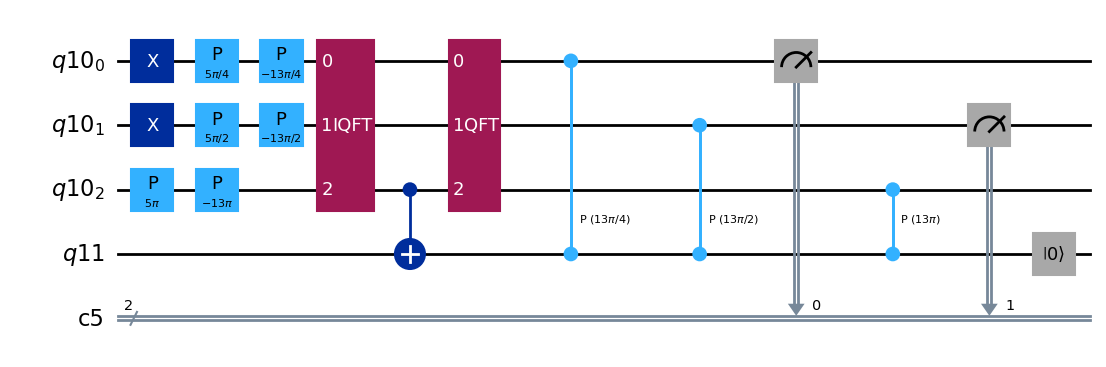

In [37]:
qc.draw(output='mpl')

In [38]:
from qiskit_aer import AerSimulator

backend = AerSimulator()
transpiled_qc = transpile(qc, backend)
job = backend.run(transpiled_qc, shots = 1024)
result = job.result()

In [39]:
result.get_counts()

{'01': 218, '10': 38, '00': 48, '11': 720}

<bound method Result.data of Result(backend_name='aer_simulator', backend_version='0.17.2', job_id='fcf90d2a-0138-46c2-93a2-22301e842ff8', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 220, '0x2': 35, '0x0': 35, '0x3': 734}), header={'creg_sizes': [['c3', 2]], 'global_phase': 3.141592653589793, 'memory_slots': 2, 'n_qubits': 4, 'name': 'circuit-76', 'qreg_sizes': [['q6', 3], ['q7', 1]], 'metadata': {}}, status=DONE, seed_simulator=3746671771, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 10, 'parallel_shots': 1, 'sample_measure_time': 0.000385208, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2, 3], 'device': 'CPU', 'time_taken': 0.000763208, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 16384, 'input_qubit_map': [[3, 3], [2, 2], [1, 1], [0, 0]], 'num_qubits': 4, 'method': 'statevector', 're